# Bouts of Sleep from a month-long recording of WT C57BL/6 mice

### First set up the working environment

In [1]:
import numpy as np  # calculations
import pandas as pd  # dataframes and IO
import matplotlib.pyplot as plt  # plotting
# show graphs/figures in notebooks
%matplotlib inline

import seaborn as sns  # statistical plots and analysis
sns.set(style="ticks")   # styling
sns.set_context("talk")

### Then import .CSV text file with the 1 month of activity data for 2 mice (with ISO-8601 encoding for the timepoints) - used for Figure4.

#### Then apply all the commands to remove unwanted columns and adjust the time to match environmental/Zeitgeber time 

In [2]:
ts_pre = pd.read_csv('../PIRdata/1monthPIRsleep.csv', parse_dates=[0],index_col=[0])
ts_pre.pop('PIR2') # remove unwarnted/empty columns
ts_pre.pop('PIR4') 
ts_pre.pop('PIR5')
ts_pre.pop('PIR6')
ts_pre.pop('Device')


ts_sH = pd.DataFrame.tshift(ts_pre,-7, freq='H', axis=0)  # shift back 7 hours 
# then shift this back 1 minute, and cut out one month of activity from slightly longer file 
ts = pd.DataFrame.tshift(ts_sH,-1, freq='T', axis=0).truncate(before='2014-08-14 00:00:00.000000',
                                                              after='2014-09-14 00:00:00.000000') 
# show end of new timeseries (ts)
ts.tail(4)

,PIR1,PIR3,LDR
Time,,,
2014-09-13 23:59:29.301,74,0,0
2014-09-13 23:59:39.303,54,0,0
2014-09-13 23:59:49.309,47,0,0
2014-09-13 23:59:59.315,51,0,0


### Next we define some functions that allow us to look at the length of bouts of sleep and when they occur

In [3]:

def sleepscan(a,bins):
    # run through trace looking for bouts of sleep (defined as 4 or more sequential '0' values)
    ss = a.rolling(bins).sum()
    y = ss==0
    return y.astype(int)   # if numerical output is required


def sleep_count(val):

    if val == 0:
        sleep_count.count = 0
    elif val == 1:
        sleep_count.count +=1
    return sleep_count.count

    sleep_count.count = 0 #static variable


def bouts_sleep(data, dataLD, ID='ID'):
    length_bins=[]
    length_timedelta=[]
    bout_start_time=[]
    bout_end_time=[]
    bout_LD=[]
    mouse_ID=[]


    for i in range(data.shape[0]):
        if (data[i]==1):                               # mark start of sleep bout
            bout_start_time.append(data.index[i])
            if dataLD[i]==0:
                bout_LD.append('D')
            else:
                bout_LD.append('L')
            #print data.index[i],data[i], 'start'

        elif (data[i-1]>=1 and data[i]==0 and i!=0):   # mark end of sleep bout
            bout_end_time.append(data.index[i-1])
            length_bins.append(data[i-1])
            #print data.index[i],data[i-1], 'end'

        elif (data[i]!=0 and i==data.shape[0]-1):       # end of record counts as end of sleep bout if in the middle
            bout_end_time.append(data.index[i])
            length_bins.append(data[i])

            #print data.index[i],data[i],'end'



    final_frame=pd.DataFrame(data={'Start_Time': bout_start_time,'End_Time':bout_end_time,
                                   'Length of bout, 10s bins':length_bins,
                                   'Light or Dark':bout_LD,'ID':ID}).set_index('Start_Time')
    return final_frame


### Add new columns to a copy of the 'ts' dataframe, with 2 steps:
###   1. using the 'sleepscan' function to define sleep
###    2. using the 'sleep_count' function for counting the periods of sleep (number of consecutive 10s bins) in the data produced by step 1 

In [4]:
sc = ts.assign(sleep1 =sleepscan(ts['PIR1'],4).apply(sleep_count),
                          sleep2 =sleepscan(ts['PIR3'],4).apply(sleep_count))
sc.head(20)

,PIR1,PIR3,LDR,sleep1,sleep2
Time,,,,,
2014-08-14 00:00:05.060,7,60,717,0,0
2014-08-14 00:00:15.065,49,58,711,0,0
2014-08-14 00:00:25.069,78,59,710,0,0
2014-08-14 00:00:35.074,67,79,709,0,0
2014-08-14 00:00:45.081,72,72,707,0,0
2014-08-14 00:00:55.087,39,57,707,0,0
2014-08-14 00:01:05.092,22,78,705,0,0
2014-08-14 00:01:15.098,14,81,705,0,0
2014-08-14 00:01:25.103,3,43,704,0,0


### Now run the analysis of bouts of sleep for the  "sleep1" column

### Using the  results of 'sleep-count' to find the start and end times of each bout, along with the length of the bout in  10s bins and if the bout started in light (L) or darkness (D)

In [5]:
# create a new dataframe, and run the 'bouts_sleep' function
# on the first column containing counts of sleep based on 40s or more of immobility

sbouts_1 =bouts_sleep(sc['sleep1'], sc['LDR'], ID='PIR1')  

### Save the resulting data and have a look at the first few lines

In [6]:
sbouts_1.to_csv('../PIRdata/bouts/wildtype_1212_SleepBouts_1month.csv')
sbouts_1.head()

,End_Time,ID,"Length of bout, 10s bins",Light or Dark
Start_Time,,,,
2014-08-14 00:02:15.130,2014-08-14 00:03:55.183,PIR1,11,L
2014-08-14 00:05:35.235,2014-08-14 00:08:35.330,PIR1,19,L
2014-08-14 00:09:25.356,2014-08-14 00:12:45.462,PIR1,21,L
2014-08-14 00:13:35.488,2014-08-14 00:24:45.837,PIR1,68,L
2014-08-14 00:25:35.863,2014-08-14 01:06:07.134,PIR1,244,L


### Add columns for hour in which bout starts of finishes (from UTC timestamps)

In [17]:
sbouts_1['start-hour']=sbouts_1.index.hour
sbouts_1['end-hour']=sbouts_1.End_Time.dt.hour

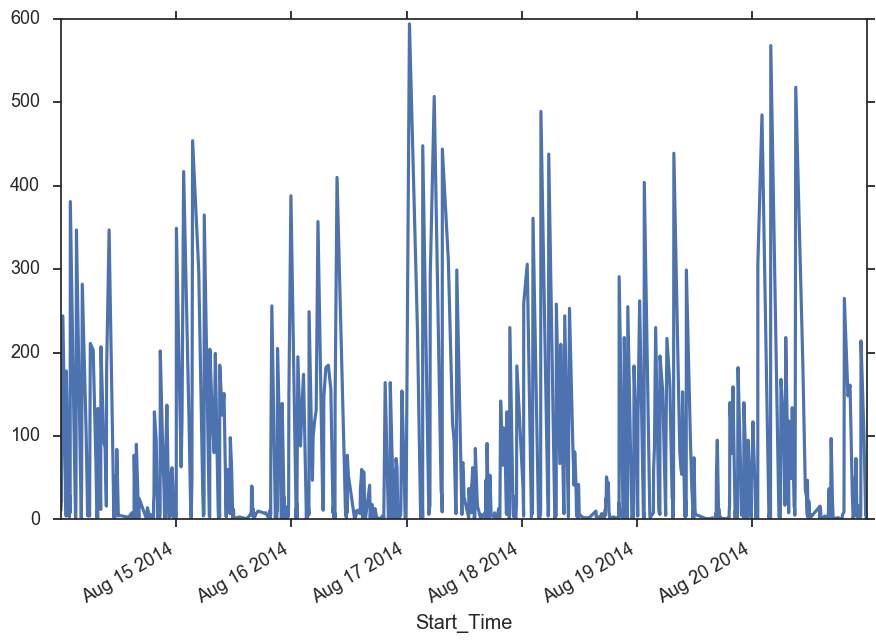

In [18]:
# Have a look at a week  

sbouts_1['Length of bout, 10s bins'].truncate(before='2014-08-14 00:00:00.000000',
                                                              after='2014-08-21 00:00:00.000000') .plot()

### Have a look at the distrubtion of bout lengths 

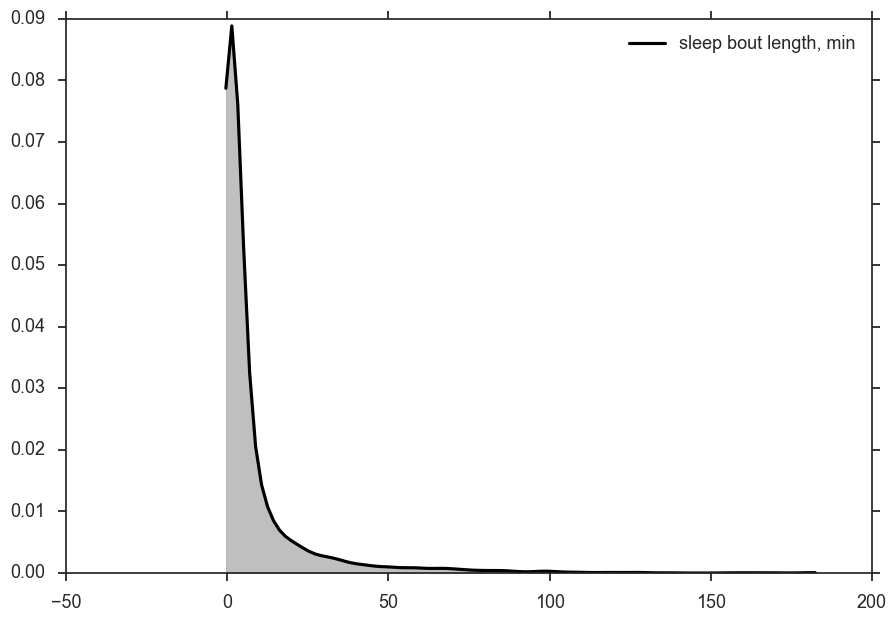

In [27]:
sns.kdeplot(sbouts_1['Length of bout, 10s bins']/6, bw='scott',label='sleep bout length, min', shade=True, color='black')

## An example of counting the number of bouts of sleep of different lengths,

#### Divinding data into bins of 0-1 min, 1-10min, 10-60min and 60min+



In [20]:
binsSleepLength = sbouts_1.groupby(['ID', pd.cut(sbouts_1['Length of bout, 10s bins'],[0,6,60,360,8640])]).count() #.aggregate([np.mean,st.sem])
binsSleepLength.fillna(0, inplace=True)
#binsActLength['Bout Length, 10s bins'].groupby(level=[2,0]) #.mean().to_clipboard()
binsSleepLength['Length of bout, 10s bins'] #.to_clipboard()

ID    Length of bout, 10s bins
PIR1  (0, 6]                      1677
      (6, 60]                     1465
      (60, 360]                    597
      (360, 8640]                   92
Name: Length of bout, 10s bins, dtype: int64

## or carry out this counting on bouts starting in darkness or in the light

In [21]:
sbouts_1D =sbouts_1.loc[sbouts_1['Light or Dark']=='D']

binsSleepLengthD = sbouts_1D.groupby(['ID', pd.cut(sbouts_1D['Length of bout, 10s bins'],[0,6,60,360,8640])]).count() 
binsSleepLengthD.fillna(0, inplace=True)


binsSleepLengthD['Length of bout, 10s bins']  #.to_clipboard()


ID    Length of bout, 10s bins
PIR1  (0, 6]                      1218
      (6, 60]                      900
      (60, 360]                    242
      (360, 8640]                    9
Name: Length of bout, 10s bins, dtype: int64

In [22]:
sbouts_1L =sbouts_1.loc[sbouts_1['Light or Dark']=='L']

binsSleepLengthL = sbouts_1L.groupby(['ID', pd.cut(sbouts_1L['Length of bout, 10s bins'],[0,6,60,360,8640])]).count() 
binsSleepLengthL.fillna(0, inplace=True)


binsSleepLengthL['Length of bout, 10s bins']  #.to_clipboard()


ID    Length of bout, 10s bins
PIR1  (0, 6]                      459
      (6, 60]                     565
      (60, 360]                   355
      (360, 8640]                  83
Name: Length of bout, 10s bins, dtype: int64

### and plot the length of bouts of sleep (starting in light or darkness) against the time of day (hour) they start

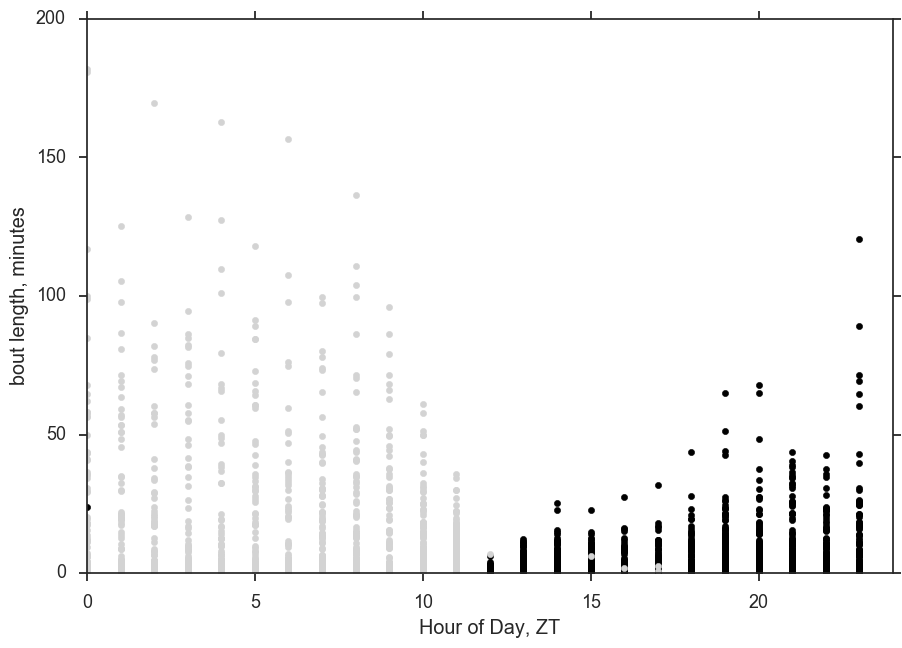

In [29]:

plt.scatter(y= sbouts_1D['Length of bout, 10s bins']/6,x=sbouts_1D['start-hour'], color='black')
plt.scatter(y= sbouts_1L['Length of bout, 10s bins']/6,x=sbouts_1L['start-hour'], color='lightgrey')
plt.ylabel('bout length, minutes')
plt.xlabel('Hour of Day, ZT')
plt.xlim(0,24)
plt.ylim(0,200)
plt.show()